In [52]:
import warnings
warnings.filterwarnings("ignore")

import os
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sqlite3
from sqlalchemy import create_engine      #database connection

from scipy import sparse
from wordcloud import WordCloud

from datetime import datetime

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

DATAPATH ="C:/Users/Shalaka/Desktop/AI/"
DATA_DB ="Train30.db"
DATA_CSV ="Train30.csv"
DATA_DB_DEADUP = "TRAIN_NEW.db"
DATA_PROCESSED = "PROCESSED.DB"

In [39]:
if not os.path.isfile(os.path.join(DATAPATH, DATA_DB)):
    start = datetime.now()
    #this sqlalchemy create_engine creates an in-memory SQLite database.
    engine = create_engine("sqlite:///"+os.path.join(DATAPATH, DATA_DB)) #https://docs.sqlalchemy.org/en/13/core/engines.html
    chunksize = 150
    cnt = 0
    for rows in pd.read_csv(os.path.join(DATAPATH, DATA_CSV), names = ["Id", "Title", "Body", "Tags"], chunksize = chunksize, iterator = True):
        cnt+=1
        rows.to_sql('Rows', engine, if_exists='append', index = False)
        if cnt % 1000 == 0:
            print("{} rows written".format(cnt*chunksize))
    print("Time taken to run this cell :", datetime.now() - start)


In [42]:
if os.path.isfile(os.path.join(DATAPATH,DATA_DB)):
    start=datetime.now()
    connection=sqlite3.connect(os.path.join(DATAPATH, DATA_DB))
    data_count=pd.read_sql_query("SELECT COUNT(*) FROM ROWS",connection)
    connection.close()
    print("Total number of rows in database = {}".format(data_count["COUNT(*)"][0]))
    print("Time taken to run this cell :",datetime.now() - start)

Total number of rows in database = 661650
Time taken to run this cell : 0:02:17.448230


In [45]:
if os.path.isfile(os.path.join(DATAPATH,DATA_DB)):
    start=datetime.now()
    connection=sqlite3.connect(os.path.join(DATAPATH, DATA_DB))
    data_dup=pd.read_sql_query("SELECT TITLE,BODY,TAGS, COUNT(*) AS COUNT_DUP FROM ROWS GROUP BY TITLE, BODY, TAGS",connection)
    connection.close()
    print("Time taken to run this cell :",datetime.now()-start)

Time taken to run this cell : 0:04:56.157482


In [46]:
data_dup.head()

,Title,Body,Tags,COUNT_DUP
0,"""SQL Injection"" issue preventing correct for...",<p>So I've been checking everything I can thin...,php forms,1
1,"$f$ a continuous function in [0,1], Show: $\l...","<p>Let $f$ be a continuous function in [0,1] a...",calculus,1
2,*** Exception: Prelude.read: no parse in Hask...,<p>This portion of code should read in two or ...,parsing haskell expression,1
3,/tmp has changed to read only,<p>Our sysadmin has left for the day and our p...,linux filesystems,1
4,500 Internal Server Error in ASP.NET MVC,<p>I am working in ASP.NET MVC. I am using par...,asp.net-mvc,1


In [62]:
data_dup.shape

(636714, 3)

In [48]:
print("Percentage of duplicate data points = {}({}%)".format((data_count["COUNT(*)"][0]-data_dup.shape[0]),((data_count["COUNT(*)"][0]-data_dup.shape[0])/data_count["COUNT(*)"][0]*100)))

Percentage of duplicate data points = 24936(3.7687599183858533%)


In [50]:
data_dup['COUNT_DUP'].value_counts()

1    612145
2     24202
3       367
Name: COUNT_DUP, dtype: int64

In [53]:
if not os.path.isfile(os.path.join(DATAPATH, DATA_DB_DEADUP)):
    engine=create_engine("sqlite:///"+os.path.join(DATAPATH,DATA_DB_DEADUP))
    data_dup=pd.DataFrame(data_dup,columns=['Title','Body','Tags'])
    data_dup.to_sql("no_dup_train",engine)

In [56]:
data_dup.shape

(636714, 3)

In [60]:
if not os.path.isfile(os.path.join(DATAPATH, DATA_DB_DEADUP)):
    con=sqlite3.connect(os.path.join(DATAPATH, DATA_DB_DEADUP))
    data_tags=pd.read_sql_query("SELECT TAGS FROM no_dup_train",con)
    data_tags_count=data_tags["Tags"].apply(lambda x:len(x.split(" ")))
    data_tags["Tags_count"]=data_tags_count
    data_tags.head()

In [61]:
data_tags.head()

,Tags,Tags_count
0,php forms,2
1,calculus,1
2,parsing haskell expression,3
3,linux filesystems,2
4,asp.net-mvc,1


In [66]:
print("Maximum number of Tags per Question = "+str(max(data_tags["Tags_count"])))
print("Minimum number of Tags per Question = "+str(min(data_tags["Tags_count"])))
print("Avg number of Tags per Question = "+str(sum(data_tags["Tags_count"])/len(data_tags["Tags_count"])))

Maximum number of Tags per Question = 5
Minimum number of Tags per Question = 1
Avg number of Tags per Question = 2.8891134795214177


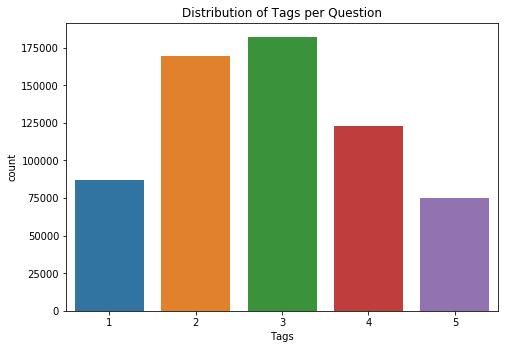

In [69]:
fig=plt.figure()
axes=fig.add_axes([0.1,0.1,1,1])
axes.set_title("Distribution of Tags per Question")
axes.set_xlabel("Tags")
axes.set_ylabel("Count")
sns.countplot(list(data_tags["Tags_count"]),ax=axes)
plt.show()

In [71]:
data_tags["Tags_count"].value_counts()

3    182329
2    169419
4    122752
1     87091
5     75123
Name: Tags_count, dtype: int64

In [ ]:
if os.path.isfile(os.path.join(DATAPATH,DATA_DB_DEADUP)):
    con=sqlite3.connect(os.path.join(DATAPATH,DATA_DB_DEADUP))
    data_tags=pd.read_sql_query("SELECT Tags FROM no_dup_train", con)
    vectorizer=CountVectorizer(tokenizer= lambda x:x.split(" "))
    data_bow=CountVectorizer()